# Tree Models for Natural Fires

In [10]:
%load_ext autoreload
%autoreload 2

import gc
import lightgbm as lgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import queries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
df_fires = queries.get_df_fires(limit=None)

gc.collect()

1742

In [4]:
df_fires_encoded = pd.get_dummies(df_fires.drop(['fire_size_class'], axis=1), columns=['month'])
columns = df_fires_encoded.columns.values

scaler = StandardScaler()
scaler.fit(df_fires_encoded)
X = scaler.transform(df_fires_encoded)
y = df_fires.fire_size_class > ''

del df_fires, df_fires_encoded
gc.collect()

num_fires = (y == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

del X, y
gc.collect()

92659 fires out of 192659 data points
No fires 52.0% of the time
X_train: 144494, X_test: 48165, y_train: 144494, y_test: 48165


In [18]:
gbm = lgbm.LGBMClassifier()

# scale_pos_weight=300,
gbm = lgbm.LGBMClassifier(objective='binary', num_leaves=100, min_data_in_leaf=200, metric='binary_logloss', max_depth=7,
                          max_bin=300, learning_rate=0.2, feature_fraction=0.5, bagging_freq=5, bagging_fraction=0.7)

drop_cols = [17, 28, 33, 34, 61]

X_train_best = np.delete(X_train, drop_cols, axis=1)
X_test_best = np.delete(X_test, drop_cols, axis=1)

gbm.fit(X_train_best, y_train)
y_pred = gbm.predict(X_test_best)
best_recall = recall_score(y_test, y_pred)

print(f'Recall for all columns: {best_recall}')

# Remove features one at a time to see if the feature is valuable
for i in range(X_train.shape[1]):
  if i not in drop_cols:
    drop_cols_try = drop_cols + [i]
    X_train_try = np.delete(X_train, drop_cols_try, axis=1)
    gbm.fit(X_train_try, y_train)

    X_test_try = np.delete(X_test, drop_cols_try, axis=1)
    y_pred = gbm.predict(X_test_try)

    recall = recall_score(y_test, y_pred)

    print(f'Recall for dropping {i} col: {recall}')

    if recall > best_recall:
      drop_cols.append(i)
      print(f'Drop cols {drop_cols}')
      best_recall = recall

drop_cols

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Recall for all columns: 0.8601173900004284
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Recall for 

[17, 28, 33, 34, 61]

In [20]:
np.take(df_fires_encoded.columns.values, drop_cols)

array(['wind_50m', 'slope_15_30', 'aspect_south', 'aspect_west',
       'month_6'], dtype=object)

In [19]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report ---------')
print(classification_report(y_test, y_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 100, 'min_data_in_leaf': 200, 'metric': 'binary_logloss', 'max_depth': 7, 'max_bin': 300, 'learning_rate': 0.2, 'feature_fraction': 0.5000000000000001, 'bagging_freq': 5, 'bagging_fraction': 0.7000000000000002}
--------- LightGBM Classification Report ---------
              precision    recall  f1-score   support

       False       0.87      0.83      0.85     24931
        True       0.82      0.87      0.84     23234

    accuracy                           0.84     48165
   macro avg       0.85      0.85      0.84     48165
weighted avg       0.85      0.84      0.84     48165



Text(0.5, 1.0, 'LGBM feature importances')

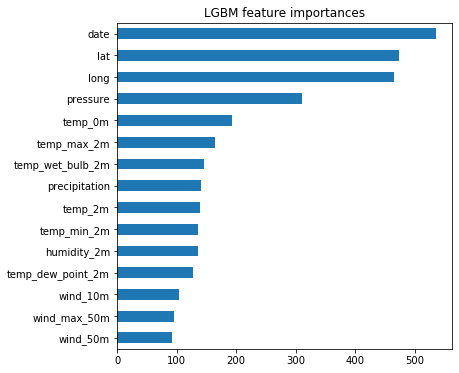

In [20]:
importances_gbm = gbm.best_estimator_.feature_importances_
importances_gbm = pd.Series(importances_gbm, index=columns).sort_values()

fig, ax = plt.subplots()
fig.set_figheight(10)
importances_gbm.plot.barh(ax=ax)
ax.set_title('LGBM feature importances')